In [106]:
# let's try using linear regression to predict the label using the irregularity score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import time

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
# Create a random forest classifier
from sklearn.ensemble import RandomForestClassifier

# Create a gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

# Create a support vector classifier
from sklearn.svm import SVC

# Create a Bayesian optimization
from bayes_opt import BayesianOptimization

# visualize using pairplot
import seaborn as sns
import matplotlib.pyplot as plt

In [107]:
# load the results
pan_tompkins_results = pd.read_csv('results/mit_bih_pan_tompkins_features.csv')
pan_tompkins_results = pan_tompkins_results.dropna().drop('record_name', axis=1)
print('results shape:', pan_tompkins_results.shape)

results shape: (500, 32)


In [108]:
labels = pan_tompkins_results['label']
print(labels.value_counts())

label
N    100
S    100
V    100
F    100
Q    100
Name: count, dtype: int64


In [109]:
from sklearn.preprocessing import StandardScaler

# remove nan values
pan_tompkins_results = pan_tompkins_results.dropna()

#  remove signal power and rr coefficient
pan_tompkins_results = pan_tompkins_results.drop(columns=['signal_power', 'rr_coefficient', 'second_order_rr_intervals'])
# pan_tompkins_results = pan_tompkins_results.drop(columns=['second_order_rr_intervals'])

# scale all the features
scaler = StandardScaler()
pan_tompkins_results[['rr_std', 'hr_std', 'signal_entropy']] = scaler.fit_transform(pan_tompkins_results[['rr_std', 'hr_std','signal_entropy']])

# split the data into train and test
X, y = pan_tompkins_results.drop('label', axis=1), pan_tompkins_results['label']

feature_names = X.columns

# normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# lets print the columns
display(X_train[:5])


array([[ 7.25890917e-01,  5.41583255e-01,  6.90209142e-01,
         6.13417533e-01, -2.02906128e-01,  6.13645575e-01,
         1.19981142e-01,  8.08244340e-01, -9.02840124e-01,
         5.14638919e-03,  1.89887164e+00,  4.78501344e-01,
        -8.12994373e-01,  1.32725278e+00, -1.16878923e+00,
         6.91721074e-01,  5.38440281e-01,  7.79079048e-01,
        -1.59363262e+00,  7.25890917e-01,  5.41583255e-01,
        -3.06931542e-01, -3.28503803e-01, -1.04096878e-01,
         5.20316723e-01,  6.09360199e-01, -3.31835405e-02,
        -2.66928431e-03],
       [ 1.12975725e-01, -7.42826139e-01,  2.16346063e-03,
        -5.83033680e-01,  7.99309321e-01, -4.58838039e-01,
         6.62647088e-01, -1.72420910e+00, -6.85416674e-01,
         2.43114410e-01,  4.10888054e-02, -7.53817153e-01,
        -5.56787729e-01, -7.08068718e-01, -5.01053574e-02,
        -7.17933434e-01, -4.91144587e-01, -6.78007112e-01,
         1.03118412e+00,  1.12975725e-01, -7.42826139e-01,
        -5.60676531e-01, -3.95

In [110]:
# plot heatmap of the correlation matrix
# plt.figure(figsize=(20, 18))
# sns.heatmap(pan_tompkins_results.drop(columns=['label']).corr(), annot=True, cmap='coolwarm')
# plt.show()

In [111]:
results = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy', 'Runtime', 'Top Predictor' ])
start_time = time.time()
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
lr_train_score = accuracy_score(y_train, lr.predict(X_train))
lr_test_score = accuracy_score(y_test, lr.predict(X_test))
lr_runtime = time.time() - start_time
top_predictor = [feature_names[np.argmax(np.abs(lr.coef_[0]))]]
result = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Train Score': [lr_train_score],
    'Test Score': [lr_test_score],
    'Runtime': [lr_runtime],
    'Top Predictor': [top_predictor]
})
print(result)
result = pd.concat([result], ignore_index=True)


                 Model  Train Score  Test Score  Runtime Top Predictor
0  Logistic Regression         0.92        0.95  0.01075     [hr_mean]


In [112]:
start_time = time.time()
# Create a logistic regression model L2
logreg2 = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
# Fit the model
logreg2.fit(X_train, y_train)
# Predict the target variable
y_pred2 = logreg2.predict(X_test)
# Calculate the accuracy
accuracy2 = accuracy_score(y_test, y_pred2)
# Calculate the runtime
runtime2 = time.time() - start_time
# Get the top predictor
# Append the results
result2 = pd.DataFrame({
    'Model': ['Logistic Regression L2'],
    'Train Accuracy': [logreg2.score(X_train, y_train)],
    'Test Accuracy': [accuracy2],
    'Runtime': [runtime2],
})
print(result2)
results = pd.concat([results, result2], ignore_index=True)

                    Model  Train Accuracy  Test Accuracy   Runtime
0  Logistic Regression L2           0.915           0.95  0.007483


/var/folders/3v/t7p60tvs5773q0xm_4_bb2tr0000gn/T/ipykernel_14367/3180948485.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result2], ignore_index=True)


In [113]:
from sklearn.calibration import LinearSVC


start_time = time.time()
# Create a linear SVM model
svm = LinearSVC(random_state=42)
# Fit the model
svm.fit(X_train, y_train)
# Predict the target variable
y_pred_svm = svm.predict(X_test)
# Calculate the accuracy
accuracy_svm = accuracy_score(y_test, y_pred_svm)
# Calculate the runtime
runtime_svm = time.time() - start_time

# Append the results
result_svm = pd.DataFrame({
    'Model': ['Linear SVM'],
    'Train Accuracy': [svm.score(X_train, y_train)],
    'Test Accuracy': [accuracy_svm],
    'Runtime': [runtime_svm],
})
print(result_svm)
results = pd.concat([results, result_svm], ignore_index=True)

        Model  Train Accuracy  Test Accuracy   Runtime
0  Linear SVM          0.9175           0.95  0.007718


In [114]:
# Create a random forest model
rf = RandomForestClassifier(random_state=42)
# Fit the model
rf.fit(X_train, y_train)
# Predict the target variable
y_pred_rf = rf.predict(X_test)
# Calculate the accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
# Calculate the runtime
runtime_rf = time.time() - start_time
# Get the top predictor
top_predictor_rf = feature_names[np.argmax(rf.feature_importances_)]
# Append the results
result_rf = pd.DataFrame({
    'Model': ['Random Forest'],
    'Train Accuracy': [rf.score(X_train, y_train)],
    'Test Accuracy': [accuracy_rf],
    'Runtime': [runtime_rf],
    'Top Predictor': [top_predictor_rf]
})
print(result_rf)
results = pd.concat([results, result_rf], ignore_index=True)

           Model  Train Accuracy  Test Accuracy  Runtime Top Predictor
0  Random Forest             1.0           0.96  0.11765  qrs_duration


In [115]:
# Create a gradient boosting model
gb = GradientBoostingClassifier(random_state=42)
# Fit the model
gb.fit(X_train, y_train)
# Predict the target variable
y_pred_gb = gb.predict(X_test)
# Calculate the accuracy
accuracy_gb = accuracy_score(y_test, y_pred_gb)
# Calculate the runtime
runtime_gb = time.time() - start_time
# Get the top predictor
top_predictor_gb = feature_names[np.argmax(gb.feature_importances_)]
# Append the results
result_gb = pd.DataFrame({
    'Model': ['Gradient Boosting'],
    'Train Accuracy': [gb.score(X_train, y_train)],
    'Test Accuracy': [accuracy_gb],
    'Runtime': [runtime_gb],
    'Top Predictor': [top_predictor_gb]
})
print(result_gb)
results = pd.concat([results, result_gb], ignore_index=True)

               Model  Train Accuracy  Test Accuracy   Runtime Top Predictor
0  Gradient Boosting             1.0           0.94  1.400914   pq_interval


In [116]:
# Display all the results as a table
display(results)

,Model,Train Accuracy,Test Accuracy,Runtime,Top Predictor
0,Logistic Regression L2,0.9150,0.95,0.007483,NaN
1,Linear SVM,0.9175,0.95,0.007718,NaN
2,Random Forest,1.0000,0.96,0.117650,qrs_duration
3,Gradient Boosting,1.0000,0.94,1.400914,pq_interval


### Let's do some parameter  hypertuning

In [117]:
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

ft_results = pd.DataFrame(columns=['Model', 'Hyperparameter', 'Train Accuracy', 'Test Accuracy', 'Runtime'])# # A4-1 Find the best hyperparameters for the 3 models

In [118]:
start_time = time.time()
# Function to optimize Logistic Regression L2
def optimize_logreg_l2(C):
    # Create a logistic regression model L2
    logreg = LogisticRegression(penalty='l2', solver='liblinear', C=C, random_state=42)
    # Fit the model
    logreg.fit(X_train, y_train)
    # Predict the target variable
    y_pred = logreg.predict(X_test)
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate the runtime
    runtime = time.time() - start_time
    return accuracy

# Create a BayesianOptimization object

def find_hyperparameter_logreg(X_train, y_train, X_test, y_test): 
    logreg_bo = BayesianOptimization(
        optimize_logreg_l2,
        {'C': (0.001, 10)}
    )

    # Perform the optimization
    logreg_bo.maximize()

    # Get the best hyperparameters
    params = logreg_bo.max['params']
    C = params['C']
    # Create a logistic regression model L2
    logreg = LogisticRegression(penalty='l2', solver='liblinear', C=C, random_state=42)
    # Fit the model
    logreg.fit(X_train, y_train)
    # Predict the target variable
    y_pred = logreg.predict(X_test)
    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate the runtime
    runtime = time.time() - start_time
    # Append the results
    result = pd.DataFrame({
        'Model': ['Logistic Regression L2'],
        'Hyperparameter': [f'C={C}'],
        'Train Accuracy': [logreg.score(X_train, y_train)],
        'Test Accuracy': [accuracy],
        'Runtime': [runtime]
    })

    return result


result = find_hyperparameter_logreg(X_train, y_train, X_test, y_test)
print(result)
ft_results = pd.concat([result], ignore_index=True)

|   iter    |  target   |     C     |
-------------------------------------
| 1         | 0.95      | 5.85      |
| 2         | 0.95      | 4.385     |
| 3         | 0.95      | 4.606     |
| 4         | 0.95      | 9.877     |
| 5         | 0.95      | 7.819     |
| 6         | 0.91      | 0.006301  |
| 7         | 0.95      | 8.931     |
| 8         | 0.95      | 6.827     |
| 9         | 0.95      | 9.454     |
| 10        | 0.95      | 6.328     |
| 11        | 0.95      | 8.346     |
| 12        | 0.95      | 5.269     |
| 13        | 0.95      | 7.329     |
| 14        | 0.96      | 10.0      |
| 15        | 0.96      | 9.985     |
| 16        | 0.96      | 9.987     |
| 17        | 0.95      | 3.836     |
| 18        | 0.95      | 3.322     |
| 19        | 0.95      | 2.816     |
| 20        | 0.95      | 2.316     |
| 21        | 0.95      | 1.823     |
| 22        | 0.95      | 1.336     |
| 23        | 0.95      | 0.8889    |
| 24        | 0.95      | 4.939     |
| 25        

In [119]:
start_time=time.time()

# Find the best hyperparameters for random forest
def optimize_random_forest(n_estimators, max_depth):
    model = RandomForestClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

def find_hyperparameter_rf(X_train, y_train, X_test, y_test):
    pbounds = {'n_estimators': (50, 200), 
               'max_depth': (5, 10)}
    optimizer = BayesianOptimization(
        f=optimize_random_forest,
        pbounds=pbounds,
        random_state=1,
    )
    optimizer.maximize()

    best_params = optimizer.max['params']
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['max_depth'] = int(best_params['max_depth'])
    print(best_params)

    result = {
        'algorithm': 'Random Forest',
        'accuracy': optimizer.max['target'],
        'hyperparameters': best_params
    }

    rf = RandomForestClassifier(**best_params, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    train_accuracy = rf.score(X_train, y_train)
    test_accuracy = accuracy_score(y_test, y_pred)
    runtime = time.time() - start_time
    result = pd.DataFrame({
        'Model': ['Random Forest'],
        'Hyperparameter': [best_params],
        'Train Accuracy': [train_accuracy],
        'Test Accuracy': [test_accuracy],
        'Runtime': [runtime]
    })

    # Now we print the top predictors
    top_predictors = [feature_names[i] for i in np.argsort(rf.feature_importances_)[::-1]]
    print("Top predictors:", top_predictors)

    return result

result = find_hyperparameter_rf(X_train, y_train, X_test, y_test)
ft_results = pd.concat([ft_results, result], ignore_index=True)
print(result)


|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
| 1         | 0.945     | 7.085     | 158.0     |
| 2         | 0.9175    | 5.001     | 95.35     |
| 3         | 0.9225    | 5.734     | 63.85     |
| 4         | 0.92      | 5.931     | 101.8     |
| 5         | 0.935     | 6.984     | 130.8     |
| 6         | 0.9375    | 9.522     | 199.9     |
| 7         | 0.9125    | 5.005     | 175.9     |
| 8         | 0.945     | 7.521     | 151.2     |
| 9         | 0.95      | 9.963     | 141.3     |
| 10        | 0.915     | 5.059     | 142.8     |
| 11        | 0.945     | 9.438     | 117.1     |
| 12        | 0.9475    | 7.161     | 102.8     |
| 13        | 0.9475    | 8.049     | 108.9     |
| 14        | 0.945     | 7.766     | 155.3     |
| 15        | 0.915     | 5.742     | 111.0     |
| 16        | 0.915     | 5.334     | 130.1     |
| 17        | 0.9325    | 6.696     | 91.23     |
| 18        | 0.945     | 7.084     | 158.1     |


In [120]:
# Find the best hyperparameters for Linear SVM

def optimize_linear_svm(C):
    model = SVC(C=C, kernel='linear', random_state=42)
    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))

def find_hyperparameter_svm(X_train, y_train, X_test, y_test):
    pbounds = {'C': (0.001, 10)}
    optimizer = BayesianOptimization(
        f=optimize_linear_svm,
        pbounds=pbounds,
        random_state=1,
    )
    optimizer.maximize()

    best_params = optimizer.max['params']
    best_params['C'] = float(best_params['C'])
    print(best_params)

    result = {
        'algorithm': 'Linear SVM',
        'accuracy': optimizer.max['target'],
        'hyperparameters': best_params
    }

    svm = SVC(**best_params, random_state=42)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    train_accuracy = svm.score(X_train, y_train)
    test_accuracy = accuracy_score(y_test, y_pred)
    runtime = time.time() - start_time
    result = pd.DataFrame({
        'Model': ['Linear SVM'],
        'Hyperparameter': [best_params],
        'Train Accuracy': [train_accuracy],
        'Test Accuracy': [test_accuracy],
        'Runtime': [runtime]
    })

    return result

result = find_hyperparameter_svm(X_train, y_train, X_test, y_test)
print(result)
ft_results = pd.concat([ft_results, result], ignore_index=True)


|   iter    |  target   |     C     |
-------------------------------------
| 1         | 0.8725    | 4.171     |
| 2         | 0.88      | 7.204     |
| 3         | 0.565     | 0.002144  |
| 4         | 0.8825    | 3.024     |
| 5         | 0.8825    | 1.468     |
| 6         | 0.88      | 2.225     |
| 7         | 0.885     | 8.96      |
| 8         | 0.875     | 5.741     |
| 9         | 0.8875    | 10.0      |
| 10        | 0.885     | 8.075     |
| 11        | 0.875     | 4.975     |
| 12        | 0.8725    | 6.488     |
| 13        | 0.8875    | 9.518     |
| 14        | 0.875     | 3.551     |
| 15        | 0.8825    | 1.789     |
| 16        | 0.885     | 8.499     |
| 17        | 0.88      | 7.638     |
| 18        | 0.88      | 2.652     |
| 19        | 0.8875    | 9.779     |
| 20        | 0.885     | 9.252     |
| 21        | 0.8725    | 5.36      |
| 22        | 0.885     | 8.278     |
| 23        | 0.8875    | 9.644     |
| 24        | 0.885     | 8.739     |
| 25        

In [121]:
# Find the best hyperparameters for gradient boosting
start_time = time.time()

def optimize_gradient_boosting(n_estimators, max_depth, learning_rate):
    model = GradientBoostingClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
    return np.mean(cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy'))


def find_hyperparameter_gb(X_train, y_train, X_test, y_test):
    
    pbounds = {'n_estimators': (10, 100), 'max_depth': (1, 10), 'learning_rate': (0.01, 0.1)}
    optimizer = BayesianOptimization(
        f=optimize_gradient_boosting,
        pbounds=pbounds,
        random_state=1,
    )

    optimizer.maximize()

    best_params = optimizer.max['params']
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['max_depth'] = int(best_params['max_depth'])
    print(best_params)

    result = {
        'algorithm': 'Gradient Boosting',
        'accuracy': optimizer.max['target'],
        'hyperparameters': best_params
    }

    gb = GradientBoostingClassifier(**best_params, random_state=42)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_test)
    train_accuracy = gb.score(X_train, y_train)
    test_accuracy = accuracy_score(y_test, y_pred)
    runtime = time.time() - start_time
    result = pd.DataFrame({
        'Model': ['Gradient Boosting'],
        'Hyperparameter': [best_params],
        'Train Accuracy': [train_accuracy],
        'Test Accuracy': [test_accuracy],
        'Runtime': [runtime]
    })

    # Now we can get the top predictors
    top_predictors = [feature_names[i] for i in np.argsort(gb.feature_importances_)[::-1]]
    print("Top predictors:", top_predictors)

    return result

result = find_hyperparameter_gb(X_train, y_train, X_test, y_test)
print(result)
ft_results = pd.concat([ft_results, result], ignore_index=True)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.84      | 0.04753   | 7.483     | 10.01     |
| 2         | 0.875     | 0.03721   | 2.321     | 18.31     |
| 3         | 0.895     | 0.02676   | 4.11      | 45.71     |
| 4         | 0.9125    | 0.05849   | 4.773     | 71.67     |
| 5         | 0.835     | 0.0284    | 8.903     | 12.46     |
| 6         | 0.82      | 0.06916   | 9.187     | 61.08     |
| 7         | 0.92      | 0.06525   | 2.965     | 75.91     |
| 8         | 0.82      | 0.01207   | 9.972     | 78.77     |
| 9         | 0.9025    | 0.08013   | 1.057     | 72.45     |
| 10        | 0.8975    | 0.08294   | 1.074     | 80.47     |
| 11        | 0.905     | 0.09262   | 2.219     | 38.2      |
| 12        | 0.825     | 0.05766   | 9.308     | 38.8      |
| 13        | 0.86      | 0.05538   | 1.243     | 32.35     |
| 14        | 0.9       | 0.09846   | 1.059     | 42.21     |
| 15    

In [122]:
pd.set_option('display.max_colwidth', None)  
display(ft_results)

,Model,Hyperparameter,Train Accuracy,Test Accuracy,Runtime
0,Logistic Regression L2,C=9.999660875690717,0.925,0.96,1.037108
1,Random Forest,"{'max_depth': 9, 'n_estimators': 141}",1.000,0.96,17.171905
2,Linear SVM,{'C': 9.999902854286887},0.985,0.93,19.805594
3,Gradient Boosting,"{'learning_rate': 0.0652529383617293, 'max_depth': 2, 'n_estimators': 75}",0.990,0.93,117.985704


In [123]:
from sklearn.metrics import confusion_matrix

# Lets print the confusion matrix
rf = RandomForestClassifier(n_estimators=141, max_depth=9, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
# add the labels to the confusion matrix
conf_matrix = pd.DataFrame(conf_matrix, index=['N', 'S', 'V', 'F', 'Q'], columns=['N', 'S', 'V', 'F', 'Q'])
display(conf_matrix)

,N,S,V,F,Q
N,20,0,0,2,2
S,0,28,0,0,0
V,0,0,24,0,0
F,0,0,0,14,0
Q,0,0,0,0,10


In [124]:

# print the classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           F       1.00      0.83      0.91        24
           N       1.00      1.00      1.00        28
           Q       1.00      1.00      1.00        24
           S       0.88      1.00      0.93        14
           V       0.83      1.00      0.91        10

    accuracy                           0.96       100
   macro avg       0.94      0.97      0.95       100
weighted avg       0.97      0.96      0.96       100



In [128]:
# Calculate sensitivity (recall) for each class
sensitivities = []
specificities = []

for i in range(len(conf_matrix)):
    # True Positives for current class
    TP = conf_matrix.iloc[i, i]
    # False Negatives for current class
    FN = conf_matrix.iloc[i, :].sum() - TP
    # False Positives for current class
    FP = conf_matrix.iloc[:, i].sum() - TP
    # True Negatives for current class
    TN = conf_matrix.values.sum() - (TP + FN + FP)
    
    # Calculate sensitivity (recall) for current class
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    sensitivities.append(sensitivity)
    
    # Calculate specificity for current class
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities.append(specificity)

# Calculate macro-averaged metrics
macro_sensitivity = np.mean(sensitivities)
macro_specificity = np.mean(specificities)

# Print results for each class
for i, (sens, spec) in enumerate(zip(sensitivities, specificities)):
    class_name = conf_matrix.index[i]
    print(f'Class {class_name}:')
    print(f'  Sensitivity: {sens:.3f}')
    print(f'  Specificity: {spec:.3f}')

print('\nMacro-averaged metrics:')
print(f'Sensitivity: {macro_sensitivity:.3f}')
print(f'Specificity: {macro_specificity:.3f}')



Class N:
  Sensitivity: 0.833
  Specificity: 1.000
Class S:
  Sensitivity: 1.000
  Specificity: 1.000
Class V:
  Sensitivity: 1.000
  Specificity: 1.000
Class F:
  Sensitivity: 1.000
  Specificity: 0.977
Class Q:
  Sensitivity: 1.000
  Specificity: 0.978

Macro-averaged metrics:
Sensitivity: 0.967
Specificity: 0.991


Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

           N       1.00      0.83      0.91        24
           S       1.00      1.00      1.00        28
           V       1.00      1.00      1.00        24
           F       0.88      1.00      0.93        14
           Q       0.83      1.00      0.91        10

    accuracy                           0.96       100
   macro avg       0.94      0.97      0.95       100
weighted avg       0.97      0.96      0.96       100




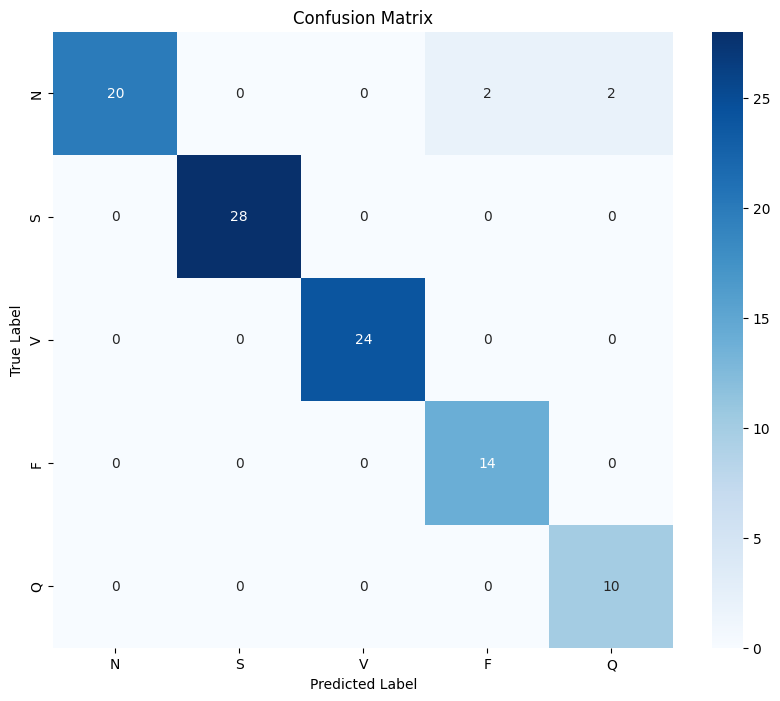

Detailed Per-class Metrics:
------------------------------------------------------------


,Sensitivity,Specificity,Precision,F1-Score
Class,,,,
N,0.833,1.000,1.000,0.909
S,1.000,1.000,1.000,1.000
V,1.000,1.000,1.000,1.000
F,1.000,0.977,0.875,0.933
Q,1.000,0.978,0.833,0.909
Macro Avg,0.967,0.991,0.942,0.950


In [129]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def display_classification_results(y_true, y_pred, class_labels):
    """
    Display comprehensive classification results including:
    1. Classification Report
    2. Confusion Matrix Heatmap
    3. Per-class and Macro-averaged Metrics
    """
    # 1. Classification Report
    print("Classification Report:")
    print("-" * 60)
    print(classification_report(y_true, y_pred, target_names=class_labels))
    print()

    # 2. Confusion Matrix Heatmap
    plt.figure(figsize=(10, 8))
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # 3. Per-class Metrics
    print("Detailed Per-class Metrics:")
    print("-" * 60)
    conf_matrix_df = pd.DataFrame(conf_matrix, 
                                 index=class_labels, 
                                 columns=class_labels)
    
    metrics = []
    for i, class_name in enumerate(class_labels):
        TP = conf_matrix_df.iloc[i, i]
        FN = conf_matrix_df.iloc[i, :].sum() - TP
        FP = conf_matrix_df.iloc[:, i].sum() - TP
        TN = conf_matrix_df.values.sum() - (TP + FN + FP)
        
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
        
        metrics.append({
            'Class': class_name,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Precision': precision,
            'F1-Score': f1
        })
    
    metrics_df = pd.DataFrame(metrics).set_index('Class')
    metrics_df.loc['Macro Avg'] = metrics_df.mean()
    
    # Round all numeric columns to 3 decimal places
    metrics_df = metrics_df.round(3)
    
    display(metrics_df)

# Use the function
class_labels = ['N', 'S', 'V', 'F', 'Q']
display_classification_results(y_test, y_pred, class_labels)

In [131]:
!pip install shap eli5


  Preparing metadata (setup.py) ... done
  Using cached attrs-24.2.0-py3-none-any.whl.metadata (11 kB)
  Using cached jinja2-3.1.4-py3-none-any.whl.metadata (2.6 kB)
  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached attrs-24.2.0-py3-none-any.whl (63 kB)
Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107721 sha256=c926a945f4ecc7e3a6a65466bed619ea6a8b4fdcb087239702ca910e45adf1e5
  Stored in directory: /Users/mlmnl/Library/Caches/pip/wheels/7b/26/a5/8460416695a992a2966b41caa5338e5e7fcea98c9d032d055c
Successfully built eli5


In [138]:
# First, make sure you have the right versions
!pip install --upgrade scikit-learn
!pip install shap

# Update scikit-learn to a newer version
!pip install --upgrade scikit-learn==1.3.0

# Update SHAP to a compatible version
!pip install --upgrade shap==0.41.0



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 1.7 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for shap: filename=shap-0.41.0-cp39-cp39-macosx_11_0_arm64.whl size=431093 sha256=04e2f10718e75d993dae1ff880e5ad42099538eb8361b876a873af05f15fbc90
  Stored in directory: /Users/mlmnl/Library/Caches/pip/wheels/69/c7/a2/7063a159ec59a3acb05f686fdc1a4a622d75ec63f07e7920e1
Successfully built shap
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: shap
    Found existing installation: shap 0.46.0
    Uninstalling shap-0.46.0:
      Successfully uninstalled shap-0

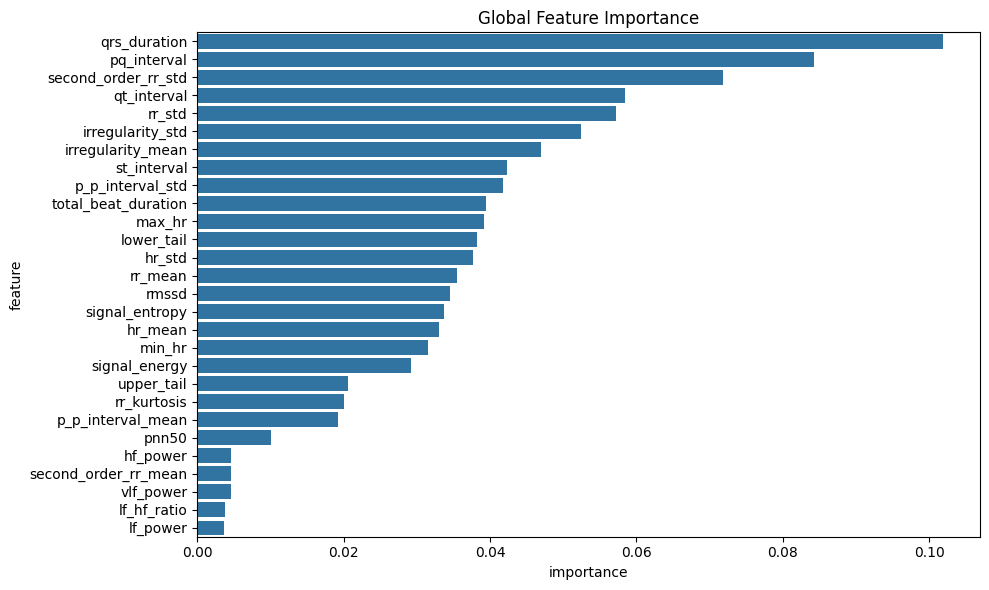


Top 5 Most Important Features:
                feature  importance
22         qrs_duration    0.101856
21          pq_interval    0.084246
11  second_order_rr_std    0.071767
26          qt_interval    0.058482
1                rr_std    0.057207


/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/miniconda3/envs/afib/lib/python3.9/site-packages/sklearn/base.py:

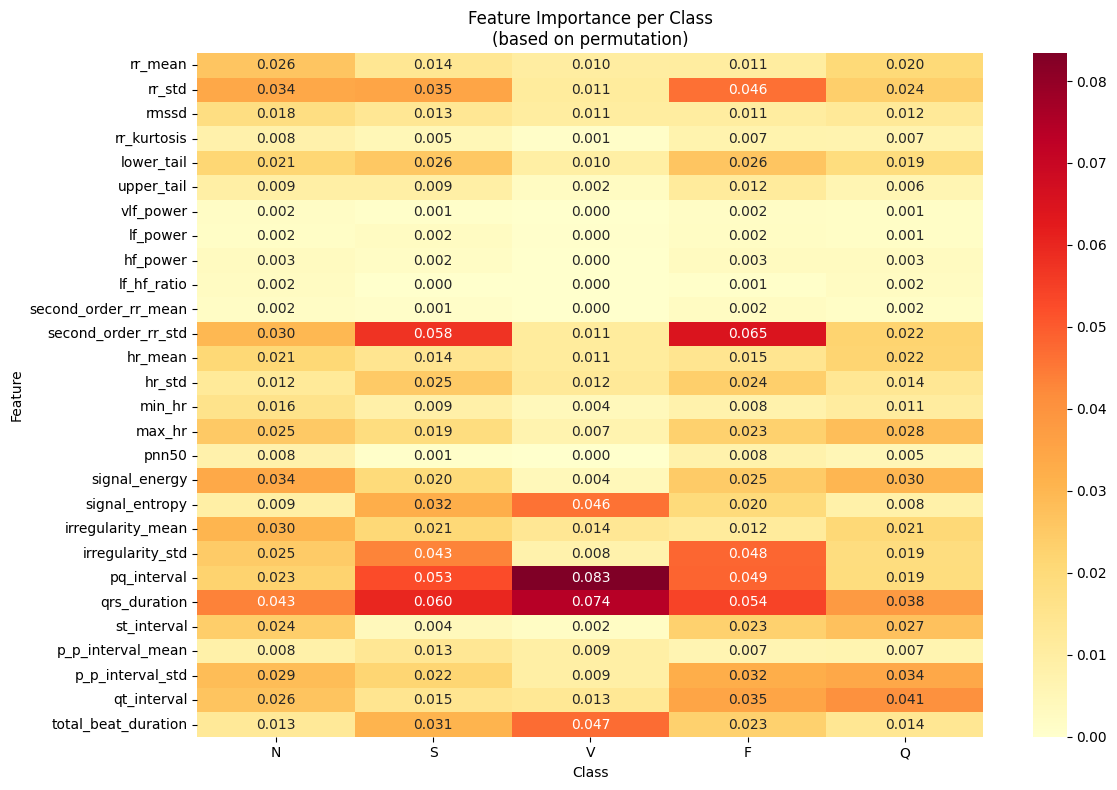

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def analyze_feature_importance_simple(model, X_test, feature_names, class_labels):
    """
    Simplified feature importance analysis
    """
    # 1. Built-in Feature Importance
    plt.figure(figsize=(10, 6))
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Create bar plot
    sns.barplot(data=importances, x='importance', y='feature')
    plt.title('Global Feature Importance')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 5 Most Important Features:")
    print(importances.head())

    # 2. Feature importance per class using predict_proba
    class_importances = []
    X_test_df = pd.DataFrame(X_test, columns=feature_names)
    
    for feature in feature_names:
        base_probs = model.predict_proba(X_test)
        feature_importance_per_class = []
        
        # Create copy and permute feature
        X_permuted = X_test_df.copy()
        X_permuted[feature] = np.random.permutation(X_permuted[feature])
        
        # Get new probabilities
        new_probs = model.predict_proba(X_permuted)
        
        # Calculate importance as difference in probability
        importance_per_class = np.mean(np.abs(base_probs - new_probs), axis=0)
        class_importances.append(importance_per_class)
    
    # Create heatmap
    class_importance_matrix = np.array(class_importances)
    plt.figure(figsize=(12, 8))
    sns.heatmap(class_importance_matrix, 
                xticklabels=class_labels,
                yticklabels=feature_names,
                cmap='YlOrRd',
                annot=True,
                fmt='.3f')
    plt.title('Feature Importance per Class\n(based on permutation)')
    plt.xlabel('Class')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# Use the function
analyze_feature_importance_simple(
    model=rf,
    X_test=X_test,
    feature_names=feature_names,
    class_labels=['N', 'S', 'V', 'F', 'Q']
)

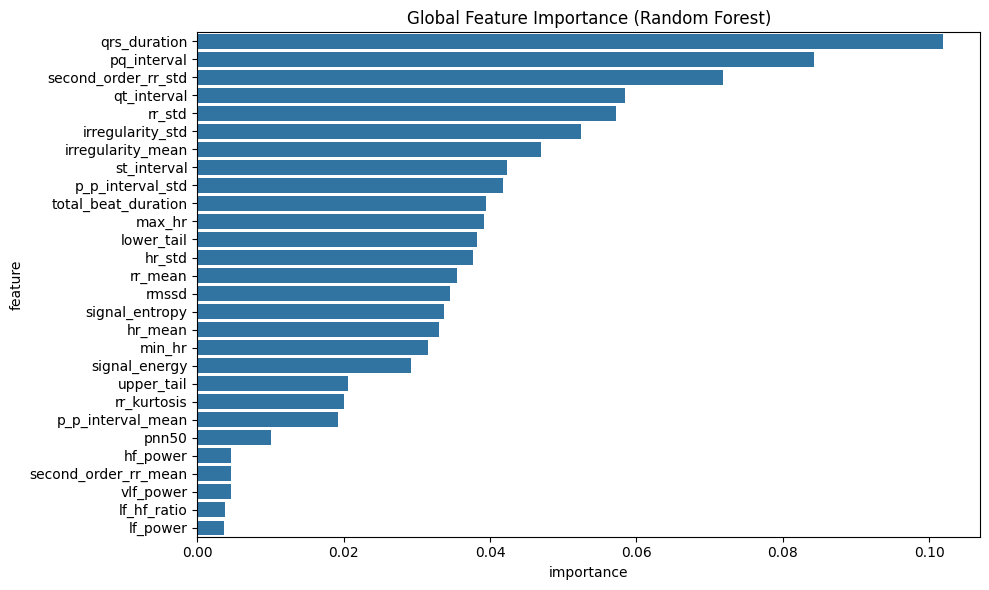

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 1000x600 with 0 Axes>

In [140]:
# First, make sure you have the right versions
!pip install --upgrade scikit-learn==1.3.0
!pip install shap==0.41.0

# Update scikit-learn to a newer version
!pip install --upgrade scikit-learn==1.3.0

# Update SHAP to a compatible version
!pip install --upgrade shap==0.41.0

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import shap

def analyze_feature_importance(model, X_test, feature_names, class_labels):
    """
    Feature importance analysis using SHAP values
    """
    # Convert X_test to DataFrame if it's not already
    X_test_df = pd.DataFrame(X_test, columns=feature_names)
    
    # Initialize SHAP explainer
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_df)
    
    # 1. Global Feature Importance Plot
    plt.figure(figsize=(10, 6))
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    sns.barplot(data=importances, x='importance', y='feature')
    plt.title('Global Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.show()
    
    # 2. SHAP Summary Plot for each class
    for i, class_name in enumerate(class_labels):
        plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values[i], 
                         X_test_df,
                         plot_type="bar",
                         show=False)
        plt.title(f'SHAP Feature Importance for Class {class_name}')
        plt.tight_layout()
        plt.show()
    
    # 3. SHAP Feature Importance Heatmap per class
    class_importance = np.zeros((len(feature_names), len(class_labels)))
    for i in range(len(class_labels)):
        class_importance[:, i] = np.abs(shap_values[i]).mean(0)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(class_importance, 
                xticklabels=class_labels,
                yticklabels=feature_names,
                cmap='YlOrRd',
                annot=True,
                fmt='.3f')
    plt.title('SHAP Feature Importance per Class')
    plt.xlabel('Class')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
    
    # 4. Print Top Features per Class
    print("\nTop 3 Most Important Features per Class:")
    print("-" * 50)
    for i, class_name in enumerate(class_labels):
        class_importances = pd.DataFrame({
            'feature': feature_names,
            'importance': np.abs(shap_values[i]).mean(0)
        }).sort_values('importance', ascending=False)
        
        print(f"\nClass {class_name}:")
        print(class_importances.head(3))

# Use the function
analyze_feature_importance(
    model=rf,
    X_test=X_test,
    feature_names=feature_names,
    class_labels=['N', 'S', 'V', 'F', 'Q']
)